# HRRR Wind Roses from OSG
Brian Blaylock  
October 6, 2017

Histogram bins for series of HRRR wind speed and direction
Shows how to plot data from wind roses binned by the Open Science Grid.

In [21]:
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
from netCDF4 import Dataset
import multiprocessing # :)
import matplotlib.pyplot as plt
import h5py

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/')
from BB_downloads.HRRR_S3 import get_hrrr_variable
from BB_wx_calcs.wind import wind_uv_to_spd, wind_uv_to_dir
from BB_basemap.draw_maps import draw_CONUS_HRRR_map

In [41]:
# Reassign Plotting Defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [6]:
# =============================================================================
# Input arguments (dates should represents the valid time)
month = 9
day = 15
hour = 0
fxx = 0

# Archvie Date Range
sDATE = datetime(2015, 4, 18, hour)
eDATE = datetime(2017, 8, 1, hour)

# Variable
var_name = 'ROSE_10m'
# =============================================================================

In [15]:
# Open a wind rose file
FILE = '../BB_HRRR/OSG_HRRR_%s_m%02d_d%02d_h%02d_f%02d.h5' % (var_name, month, day, hour, fxx)
h5 = h5py.File(FILE, 'r')

rose = h5['rose tables']

# Dimensions: [latitude, longitude, speed bins, direction bins]

The `rose tables` dimesions are [latitude, longitude, speed, bins, direction bins]

In [76]:
speed_bins = h5['wind speed bins'][:]
wind_direction_edges = h5['wind direction edges'][:]

print 'Wind Speed Bins:', speed_bins
for i in range(len(speed_bins)-1):
    print '    index [%s]: %s-%s m/s' % (i, speed_bins[i], speed_bins[i+1])

print ""
print 'Wind Direction Bins', wind_direction_edges
directions = ['North', 'North-East', 'East', 'South-East', 'South', 'South-West', 'West', 'North-West']
for i in range(len(directions)):
    print '    index [%s]: %s' % (i, directions[i])

print ""
print np.shape(rose[0,0])

Wind Speed Bins: [  0.   2.   4.   6.   8.  inf]
    index [0]: 0.0-2.0 m/s
    index [1]: 2.0-4.0 m/s
    index [2]: 4.0-6.0 m/s
    index [3]: 6.0-8.0 m/s
    index [4]: 8.0-inf m/s

Wind Direction Bins [ 337.5   22.5   67.5  112.5  157.5  202.5  247.5  292.5]
    index [0]: North
    index [1]: North-East
    index [2]: East
    index [3]: South-East
    index [4]: South
    index [5]: South-West
    index [6]: West
    index [7]: North-West

(5, 8)


In [73]:
# Wind bins table for a point
rose[100, 100, :, :]

array([[ 1,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  4,  0,  0,  0,  1,  2,  2],
       [17, 18,  1,  0,  0,  0,  2,  2],
       [11, 19,  0,  0,  0,  1,  0,  0],
       [ 3,  2,  0,  0,  0,  0,  0,  1]])

In [74]:
# Wind bins table for a point, ONLY NORTH WINDS
rose[100, 100, :, 0]

array([ 1,  3, 17, 11,  3])

In [75]:
# Wind bins table for a point, ONLY NORTH WINDS, GREATER THAN 6 m/s
rose[100, 100, 3:, 0]

array([11,  3])

In [19]:
# total samples in each point (should be same at every grid point)
samples = np.sum(rose[0,0]) # same as np.sum(rose[0, 0, :, :])
print 'Total number of samples:', samples

Total number of samples: 90


In [18]:
# total samples between last speed bin and infinity (top left corner)
count_highest_spd_bin = np.sum(rose[0,0][-1,:])
print count_highest_spd_bin

7


In [20]:
# total samples of north wind at a point (top left corner)
count_highest_spd_bin = np.sum(rose[0,0][:,0])
print count_highest_spd_bin

20


In [24]:
# Create map object
m = draw_CONUS_HRRR_map()

# Get lat/lon values for HRRR grid
H = get_hrrr_variable(datetime(2017, 1, 1), variable='TMP:2 m')

./temp_2017010100_f00_TMP.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 54:37331742:d=2017010100:TMP:2 m above ground:anl

range: 37331742 38579226


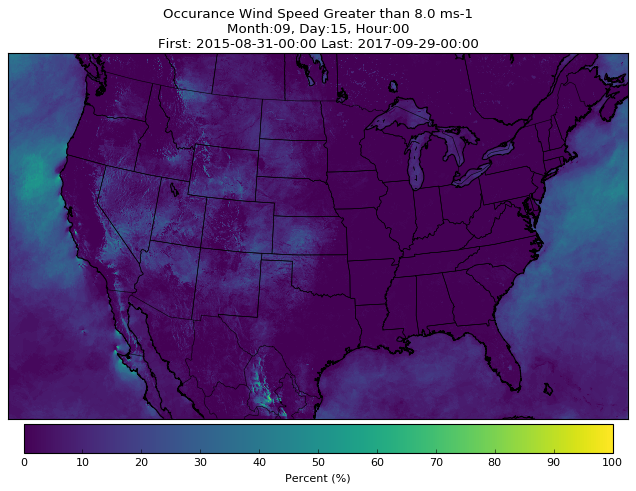

In [49]:
# Plot CONUS with count of highest wind bin (in this case, winds greater than 8) in all directions
CONUS_highest_bin_count = np.sum(rose[:,:,-1,:], axis=2)

m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.pcolormesh(H['lon'], H['lat'], CONUS_highest_bin_count/float(samples)*100,
             latlon=True,
             cmap='viridis',
             vmax=100, vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent (%)')

plt.title('Occurance Wind Speed Greater than %s ms-1\nMonth:%02d, Day:%02d, Hour:%02d\nFirst: %s Last: %s' \
          % (h5['wind speed bins'][-2], month, day, hour, h5['Beginning Date'].value, h5['Ending Date'].value))

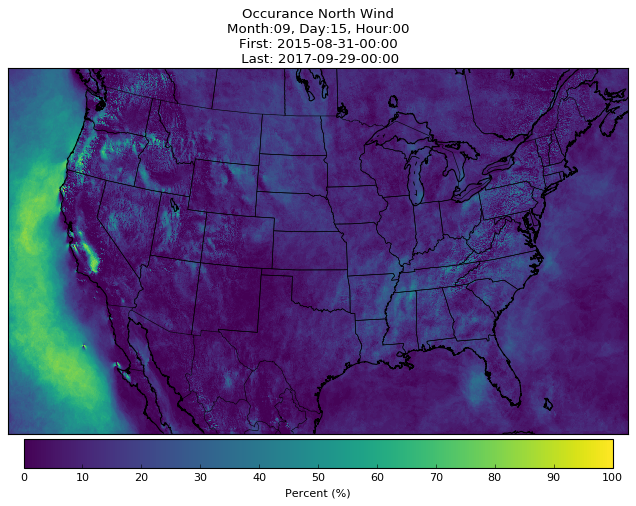

In [48]:
# Plot CONUS with north wind at all wind speeds
CONUS_north_wind_count = np.sum(rose[:,:,:,0], axis=2)

m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.pcolormesh(H['lon'], H['lat'], CONUS_north_wind_count/float(samples)*100,
             latlon=True,
             cmap='viridis',
             vmax=100, vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent (%)')
cb = plt.title('Occurance North Wind\nMonth:%02d, Day:%02d, Hour:%02d\nFirst: %s\n Last: %s' \
               % (month, day, hour, h5['Beginning Date'].value, h5['Ending Date'].value))

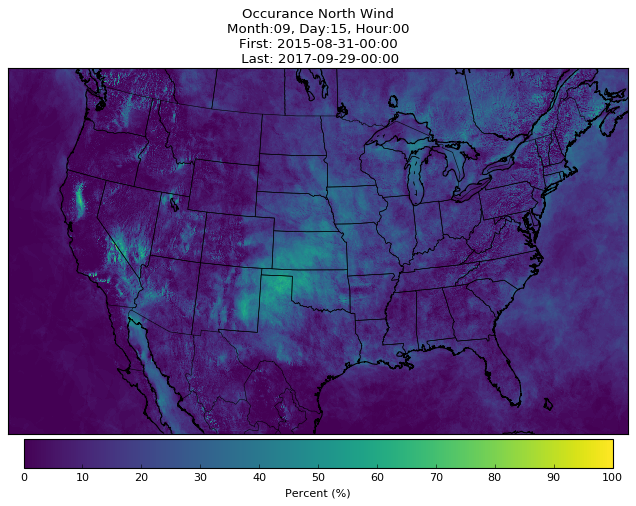

In [50]:
# Plot CONUS with south wind at all wind speeds
CONUS_south_wind_count = np.sum(rose[:,:,:,4], axis=2)

m.drawcoastlines(); m.drawstates(); m.drawcountries()
m.pcolormesh(H['lon'], H['lat'], CONUS_south_wind_count/float(samples)*100,
             latlon=True,
             cmap='viridis',
             vmax=100, vmin=0)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Percent (%)')
cb = plt.title('Occurance North Wind\nMonth:%02d, Day:%02d, Hour:%02d\nFirst: %s\n Last: %s' \
               % (month, day, hour, h5['Beginning Date'].value, h5['Ending Date'].value))

In [51]:
## ============================================================================
# Pluck a point from HRRR grid
latlon = h5py.File('/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/daily30_20150418-20170801/OSG_HRRR_latlon.h5', 'r')
lat = latlon['latitude'].value
lon = latlon['longitude'].value

wbb_lat = 40.76623
wbb_lon = -111.84755

from BB_data.grid_manager import pluck_point_new
from pylab import poly_between
from BB_rose.windrose import WindroseAxes

I, J = pluck_point_new(wbb_lat, wbb_lon, lat, lon)
i = I[0]
j = J[0]

wbb_rose_table = rose[i, j]

## ============================================================================
# Plot a rose for the point
new_bins = bins[0:-1]
new_nbins = num_spd_bins
new_nsector = num_dir_sectors
new_cmap = mpl.cm.jet
new_colors = [new_cmap(i) for i in np.linspace(0.0, 1.0, new_nbins)]
new_angles = np.arange(0, -2*np.pi, -2*np.pi/new_nsector) + np.pi/2

plot_angles = np.hstack((new_angles, new_angles[-1]-2*np.pi/new_nsector))
plot_vals = np.hstack((wbb_rose_table,
                       np.reshape(wbb_rose_table[:,0],
                                 (wbb_rose_table.shape[0], 1))))

fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='w')
rect = [0.1, 0.1, 0.8, 0.8]
ax = WindroseAxes(fig, rect, axisbg='w')
fig.add_axes(ax)

opening = 0.8
dtheta = 2*np.pi/new_nsector
opening = dtheta*opening

wbb_rose_percent = wbb_rose_table/float(samples)

for j in range(new_nsector):
    offset = 0
    for i in range(new_nbins):
        if i > 0:
            offset += wbb_rose_percent[i-1, j]
        val = wbb_rose_percent[i, j]
        zorder = ZBASE + new_nbins - i
        patch = mpl.patches.Rectangle((plot_angles[j]-opening/2, offset), opening, val,
                                      facecolor=new_colors[i], edgecolor=None, zorder=zorder)
        ax.add_patch(patch)
        if j == 0:
            ax.patches_list.append(patch)


handles = list()
for p in ax.patches_list:
    if isinstance(p, mpl.patches.Polygon) or \
    isinstance(p, mpl.patches.Rectangle):
        color = p.get_facecolor()
    elif isinstance(p, mpl.lines.Line2D):
        color = p.get_color()
    else:
        raise AttributeError("Can't handle patches")
    handles.append(mpl.patches.Rectangle((0, 0), 0.2, 0.2,
        facecolor=color, edgecolor='black'))


labels = np.copy(bins)
labels = ["[%.1f : %0.1f] m s-1" %(labels[i], labels[i+1]) \
            for i in range(len(labels)-1)]
ax.legend_ = mpl.legend.Legend(ax, handles, labels, loc='lower left')

NameError: name 'bins' is not defined